# Configuration

In [16]:
!pip install mne

In [17]:
import matplotlib.pyplot as plt
from mne.decoding import CSP
import numpy as np
import os
import pandas as pd
from scipy import io
from sklearn.svm  import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
%matplotlib inline

from utils import best_model_on_TestSet, customized_GridSearch, plot_models_acc, prepare_Data 


# Read Data

In [18]:
!unzip /content/drive/MyDrive/BCI_StrokeRehab/Risultati_2s.zip # Replace with your file path

Archive:  /content/drive/MyDrive/BCI_StrokeRehab/Risultati_2s.zip
replace Risultati/Processed_P1_post_test.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


We store data into a nested dictionary with the following structure:

```
  data = {"patient1":{
                      "pre" : {"train": {"DxRaw" : [],
                                       "DxFilt" : [],
                                       "SxRaw" : [],
                                       "SxFilt" : [],
                                       "tr" : []},

                              "test" : {"DxRaw" : [],
                                       "DxFilt" : [],
                                       "SxRaw" : [],
                                       "SxFilt" : [],
                                       "tr" : []}},

                      "post": {"train": {"DxRaw" : [],
                                        "DxFilt" : [],
                                        "SxRaw" : [],
                                        "SxFilt" : [],
                                        "tr" : []},

                               "test" : {"DxRaw" : [],
                                        "DxFilt" : [],
                                        "SxRaw" : [],
                                        "SxFilt" : [],
                                        "tr" : []}}},

          "patient2":{"pre":{...},
                     "post": {...}},

          "patient3":{...}
        }
```


In [19]:
path = "/content/Risultati" # Replace with your own folder path

data = {"patient1":{"pre":{},
                    "post": {}},
        "patient2":{"pre":{},
                    "post": {}},
        "patient3":{"pre":{},
                    "post": {}}
        }

 
# Patient 1
processed_P1_pre_training = io.loadmat(path + '/Processed_P1_pre_training.mat')
processed_P1_pre_test = io.loadmat(path + '/Processed_P1_pre_test')
processed_P1_post_training= io.loadmat(path + '/Processed_P1_post_training.mat')
processed_P1_post_test= io.loadmat(path + '/Processed_P1_post_test.mat')

# Patient 2
processed_P2_pre_training = io.loadmat(path + '/Processed_P2_pre_training.mat')
processed_P2_pre_test = io.loadmat(path + '/Processed_P2_pre_test')
processed_P2_post_training= io.loadmat(path + '/Processed_P2_post_training.mat')
processed_P2_post_test= io.loadmat(path + '/Processed_P2_post_test.mat')

# Patient 3
processed_P3_pre_training = io.loadmat(path + '/Processed_P3_pre_training.mat')
processed_P3_pre_test = io.loadmat(path + '/Processed_P3_pre_test')
processed_P3_post_training= io.loadmat(path + '/Processed_P3_post_training.mat')
processed_P3_post_test= io.loadmat(path + '/Processed_P3_post_test.mat')

keys = list(processed_P1_pre_training.keys())
for key in keys[:3]:
  processed_P1_pre_training.pop(key)
  processed_P1_pre_test.pop(key)
  processed_P1_post_training.pop(key)
  processed_P1_post_test.pop(key)

  processed_P2_pre_training.pop(key)
  processed_P2_pre_test.pop(key)
  processed_P2_post_training.pop(key)
  processed_P2_post_test.pop(key)

  processed_P3_pre_training.pop(key)
  processed_P3_pre_test.pop(key)
  processed_P3_post_training.pop(key)
  processed_P3_post_test.pop(key)

data["patient1"]["pre"]["train"]= processed_P1_pre_training
data["patient1"]["pre"]["test"]= processed_P1_pre_training
data["patient1"]["post"]["train"] = processed_P1_pre_training
data["patient1"]["post"]["test"] = processed_P1_pre_training

data["patient2"]["pre"]["train"]= processed_P2_pre_training
data["patient2"]["pre"]["test"]= processed_P2_pre_training
data["patient2"]["post"]["train"] = processed_P2_pre_training
data["patient2"]["post"]["test"] = processed_P2_pre_training

data["patient3"]["pre"]["train"]= processed_P3_pre_training
data["patient3"]["pre"]["test"]= processed_P3_pre_training
data["patient3"]["post"]["train"] = processed_P3_pre_training
data["patient3"]["post"]["test"] = processed_P3_pre_training

In [20]:
# Look at data shape
for k,v in data.items():
  for kk,vv, in v.items():
    print()
    for kkk, vvv in vv.items():
      for kkkk, vvvv in vvv.items():
          print(k, kk, kkk, kkkk,"shape:", vvvv.shape)
  print()


patient1 pre train DxFilt shape: (40, 16, 512)
patient1 pre train DxRaw shape: (40, 16, 512)
patient1 pre train SxFilt shape: (40, 16, 512)
patient1 pre train SxRaw shape: (40, 16, 512)
patient1 pre train tr shape: (1, 80)
patient1 pre test DxFilt shape: (40, 16, 512)
patient1 pre test DxRaw shape: (40, 16, 512)
patient1 pre test SxFilt shape: (40, 16, 512)
patient1 pre test SxRaw shape: (40, 16, 512)
patient1 pre test tr shape: (1, 80)

patient1 post train DxFilt shape: (40, 16, 512)
patient1 post train DxRaw shape: (40, 16, 512)
patient1 post train SxFilt shape: (40, 16, 512)
patient1 post train SxRaw shape: (40, 16, 512)
patient1 post train tr shape: (1, 80)
patient1 post test DxFilt shape: (40, 16, 512)
patient1 post test DxRaw shape: (40, 16, 512)
patient1 post test SxFilt shape: (40, 16, 512)
patient1 post test SxRaw shape: (40, 16, 512)
patient1 post test tr shape: (1, 80)


patient2 pre train DxFilt shape: (40, 16, 512)
patient2 pre train DxRaw shape: (40, 16, 512)
patient2 pr

# Grid Search


In [21]:
##########################
# Grid Search Parameters #
##########################

# CSP parameters 
parameters_csp = {
    'csp__n_components' : (4,6,8),
    'csp__log' : (True,)}


# LogReg and SVC Parameters
parameters_clf = { 'clf__C': (0.25, 0.5, 0.75,)}

# MLP Parameters
parameters_mlp = {'clf__hidden_layer_sizes': (100,),
                  'clf__activation' : ('relu',), 
                  'clf__max_iter': (1000,)}

# CSP
csp = CSP()

# Classifiers
svc = SVC()
logreg= LogisticRegression()
mlp = MLPClassifier()

In [22]:
# Prepare Training Data
X_train, y_train = prepare_Data(data, is_train = True)
# Perform Grid Search
grid_search = customized_GridSearch(mlp, csp, parameters_mlp, parameters_csp, X_train, y_train)

Performing grid search...
pipeline: ['csp', 'clf']
parameters:
{'csp__n_components': (4, 6, 8), 'csp__log': (True,), 'clf__hidden_layer_sizes': (100,), 'clf__activation': ('relu',), 'clf__max_iter': (1000,)}
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Computing rank from data with rank=None


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   10.6s finished


    Using tolerance 2.8e+02 (2.2e-16 eps * 16 dim * 7.9e+16  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.4e+02 (2.2e-16 eps * 16 dim * 6.7e+16  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
done in 11.679s

Best CV score: 0.598
Best parameters set:
	clf__activation: 'relu'
	clf__hidden_layer_sizes: 100
	clf__max_iter: 1000
	csp__log: True
	csp__n_components: 4


## Test Model

In [23]:
# Test the best model on each test dataset

total_scores = {} # Best model accuracy
chance_levels = {} # Chance levels
best_parameters = {} # Best model parameters

patients = ['patient1', 'patient2', 'patient3']
mode_paramters = [['pre','Raw'],
                  ['pre','Filt'],
                  ['post','Raw'],
                  ['post','Filt']]

# Run test
for patient in patients:
  total_scores[patient] = {}
  chance_levels[patient] = {}
  best_parameters[patient] = {}
  for mode in mode_paramters:
        print(patient, mode)
        X_test, y_test = prepare_Data(data, patient, mode, is_train = False)
        best_params, scores = best_model_on_TestSet(grid_search, X_test, y_test)

        class_balance = np.mean(y_test == y_test[0])
        class_balance = max(class_balance, 1. - class_balance)
        total_scores[patient][mode[0] + '_'+ mode[1]] = np.mean(scores)
        chance_levels[patient][mode[0] + '_'+ mode[1]] = class_balance
        best_parameters[patient][mode[0] + '_'+ mode[1]] = best_params

patient1 ['pre', 'Raw']
Test score with best_estimator_: 0.688


Classification Report Test Data
              precision    recall  f1-score   support

        -1.0       0.65      0.82      0.73        40
         1.0       0.76      0.55      0.64        40

    accuracy                           0.69        80
   macro avg       0.70      0.69      0.68        80
weighted avg       0.70      0.69      0.68        80

patient1 ['pre', 'Filt']
Test score with best_estimator_: 0.500


Classification Report Test Data
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        40
         1.0       0.50      1.00      0.67        40

    accuracy                           0.50        80
   macro avg       0.25      0.50      0.33        80
weighted avg       0.25      0.50      0.33        80

patient1 ['post', 'Raw']
Test score with best_estimator_: 0.688


Classification Report Test Data
              precision    recall  f1-score   support

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        -1.0       1.00      0.05      0.10        39
         1.0       0.52      1.00      0.68        40

    accuracy                           0.53        79
   macro avg       0.76      0.53      0.39        79
weighted avg       0.76      0.53      0.39        79

patient3 ['post', 'Raw']
Test score with best_estimator_: 0.684


Classification Report Test Data
              precision    recall  f1-score   support

        -1.0       0.63      0.87      0.73        39
         1.0       0.80      0.50      0.62        40

    accuracy                           0.68        79
   macro avg       0.71      0.69      0.67        79
weighted avg       0.72      0.68      0.67        79

patient3 ['post', 'Filt']
Test score with best_estimator_: 0.532


Classification Report Test Data
              precision    recall  f1-score   support

        -1.0       1.00      0.05      0.10        39
         1.0       0.52      1.00      0

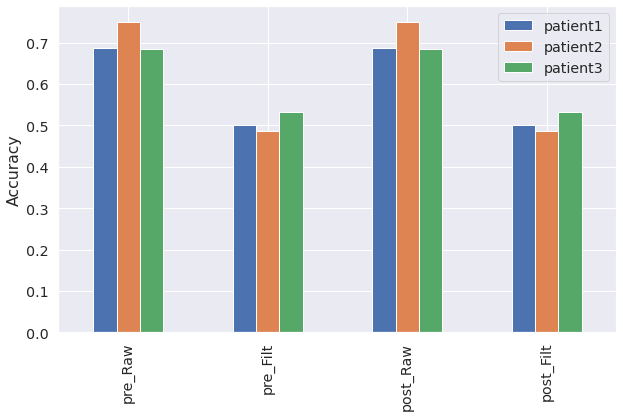

In [24]:
# Best model accuracy on each dataset
pd.DataFrame(total_scores).plot(kind='bar', figsize = (10,6))
plt.ylabel("Accuracy");

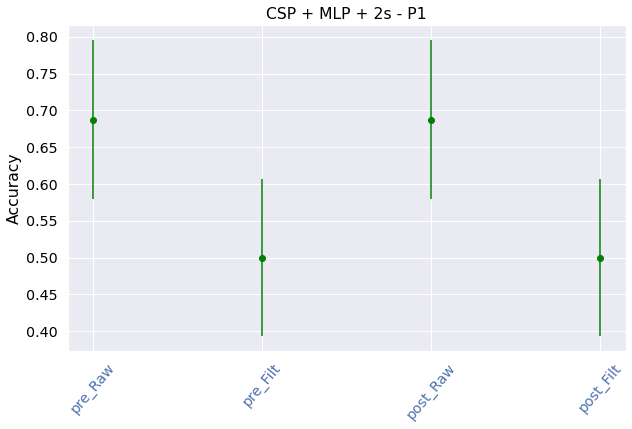

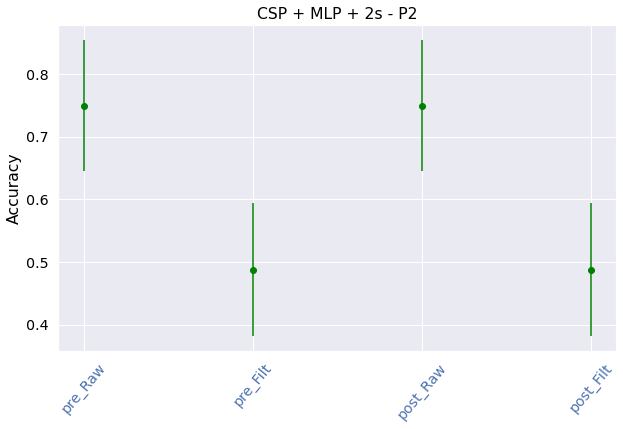

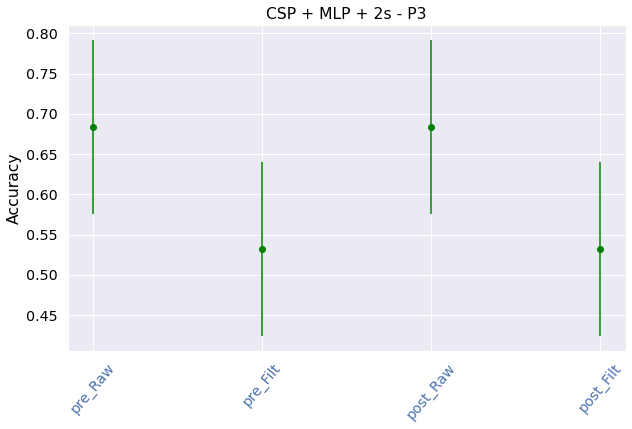

In [25]:
plot_models_acc(total_scores['patient1'], total_scores['patient2'], total_scores['patient3'], N=80, alpha = .95, title = 'CSP + MLP + 2s');